In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('../data/ibm_stock_prices_2000_2025.csv', parse_dates=['Date'], skiprows=[1]).drop(columns=['Adj Close', 'Volume'])
df.set_index('Date', inplace=True)

In [6]:
def create_sequence(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, :])
        y.append(data.iloc[i + seq_length, 3])
    return np.array(X), np.array(y)

#define model

In [7]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

In [8]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs=10, batch_size=30):
  model.train()
  for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
      x_batch = x_train[i:i+batch_size]
      y_batch = y_train[i:i+batch_size]
      optimizer.zero_grad()
      loss = criterion(model(x_batch),y_batch)
      loss.backward()
      optimizer.step()
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [9]:
def evaluate_model(neurons, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=30):
  model = LSTMModel(input_size = 4, hidden_size= neurons, output_size=1)
  criterion = nn.MSELoss()
  if opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  train_model(model, criterion, optimizer, x_train, y_train, epochs=epochs, batch_size=batch_size)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)
  mse = criterion(y_test, y_pred)
  return mse, model

In [ ]:
seq_lengths = [20, 30, 40, 50]
logger = []
num_features = 4
for seq_length in seq_lengths:
    X,y = create_sequence(df, seq_length)
    train_size = int(len(df)*0.8)
    X_train, X_test = X[0:train_size, :], X[train_size:, :]
    y_train, y_test = y[0:train_size], y[train_size:]
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    scalerX = MinMaxScaler(feature_range =(0,1))
    scalery = MinMaxScaler(feature_range = (0,1))

    x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
    x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
    y_train = scalery.fit_transform(y_train.reshape(-1,1))
    y_test = scalery.transform(y_test.reshape(-1,1))
    x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
    x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
    y_train = torch.from_numpy(y_train).float()
    y_test = torch.from_numpy(y_test).float()
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    best_mse = float('inf')
    best_params = {}
    neurons = [200,500,1000]
    optimizers = ['adam', 'sgd']

    for n in neurons:
        for opt in optimizers:
            mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test)
            print(f'Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
            if mse < best_mse:
                best_mse = mse
                best_params = {'neurons': n, 'optimizer': opt}
                best_model = model
            logger.append({
                'seq_length': seq_length,
                'neurons': n,
                'optimizer': opt,
                'mse': mse.item()
            })

(5095, 20, 4) (1254, 20, 4) (5095,) (1254,)
torch.Size([5095, 20, 4]) torch.Size([1254, 20, 4]) torch.Size([5095, 1]) torch.Size([1254, 1])


Best MSE: 0.0004663288127630949
Best Params: {'neurons': 200, 'optimizer': 'adam'}
MSE: 0.0004663288709707558


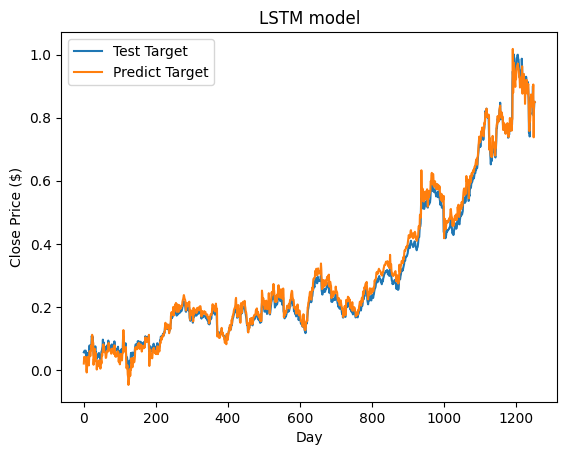

In [17]:

print(f'Best MSE: {best_mse}')
print(f'Best Params: {best_params}')

# Dự đoán và vẽ đồ thị
best_model.eval()
with torch.no_grad():
    y_pred = best_model(x_test)

mse = mean_squared_error(y_test.numpy(), y_pred.numpy())
print(f'MSE: {mse}')

plt.title("LSTM model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test.numpy(), label="Test Target")
plt.plot(y_pred.numpy(), label="Predict Target")
plt.legend()
plt.show()